#### Comic Vine API Demonstration

##### First
Some modules and loading in an API key which can be created at the [Comic Vine API page](https://comicvine.gamespot.com/api/). 

In [421]:
import pandas as pd
import requests
import json
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import statsmodels.formula.api as smf
import numpy as np

In [422]:
cv_key = pd.read_csv('comicvine key.txt')
cv_key.keys()

Index(['API-key'], dtype='object')

In [423]:
key = cv_key['API-key'].iloc[0]

##### Second

I am just going to create a few variables to hold the api base URL and structure the parameter that holds your API key.

In [391]:
api_url = 'https://comicvine.gamespot.com/api/'
key_url = 'api_key='+str(key)

In [392]:
failed_request = characters_response = requests.get(api_url + 'characters/?' + key_url + '&format=json')
failed_request.status_code

403

In [393]:
with open('comicvine_out.html', 'w') as t:
    t.write(failed_request.text)

##### Explaining the solution:
From the output html file, scroll down to the bottom and you will find the following text that explains the reason for the 403 status code:

>... Or you're running a bot that does not provide a unique user agent.
> 		<p>Please provide a UNIQUE user agent that describes you. Do not use a default user agent like "PHP", "Java", "Ruby", "wget", "curl" etc.<p>
> 		You MUST provide a UNIQUE user agent. ...and for God's sake don't impersonate another bot like Google Bot that will for sure 
> 		get you permanently banned.

This just means that header information is required for the API to return data. In this case, the header does not require the API key, but instead just needs what is called a User Agent.

This User Agent can take many forms. What I include below is a default User Agent which is not entirely what this API wants, but it works well enough for this demonstration.

To find your unique user agent, open any browser and go to this [helpful header utility](https://www.whatismybrowser.com/detect/what-is-my-user-agent/).
The top box starting with something like: `Mozilla/5.0 (Windows...` is what you could use for the `User-Agent` headers parameter instead of the default used in the example below.

In [394]:
characters_response = requests.get(api_url + 'characters/?' + key_url + '&format=json', headers = {'User-agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/605.1.15 (KHTML, like Gecko) Version/18.0.1 Safari/605.1.15'})

In [395]:
characters_response.status_code

200

In [396]:
cha_dict = json.loads(characters_response.text)
cha_dict.keys()

dict_keys(['error', 'limit', 'offset', 'number_of_page_results', 'number_of_total_results', 'status_code', 'results', 'version'])

In [397]:
len(cha_dict['results'])

100

In [398]:
#cha_dict['results'][0]

In [399]:
cha_df = pd.DataFrame(cha_dict['results'])
#cha_df.head()

In [400]:
spawn_response = requests.get(api_url + 'character/4005-3381?' + key_url + '&format=json', headers = {'User-agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/605.1.15 (KHTML, like Gecko) Version/18.0.1 Safari/605.1.15'})

In [401]:
spawn_response.status_code

200

In [402]:
spawn = json.loads(spawn_response.text)

In [403]:
spawn.keys()

dict_keys(['error', 'limit', 'offset', 'number_of_page_results', 'number_of_total_results', 'status_code', 'results', 'version'])

trial for figuring out how to call a character

                                                 PAGE BREAK LOL

In [404]:
char_list = ['4005-24863', '4005-3381', '4005-40550', '4005-51840', '4005-42443', '4005-5210', '4005-48901', '4005-17996', '4005-5209','4005-5195','4005-5182','4005-47906', '4005-6538', '4005-64035', '4005-17859']
responses = []
for i in char_list:
    resp = requests.get(api_url+'character/'+str(i)+'?'+key_url + '&format=json', headers = {'User-agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/605.1.15 (KHTML, like Gecko) Version/18.0.1 Safari/605.1.15'} )
    chj = json.loads(resp.text)
    responses.append(chj['results'])

In [405]:
print(api_url + 'character/' + str(i) + '?' + key_url)

https://comicvine.gamespot.com/api/character/4005-17859?api_key=61e513aa5ef93ccd3df87a74b91f41a6fce71448


In [406]:
ic_df = pd.DataFrame(responses)
#ic_df

I have begun to put the characters that I would like to focus on in their own dataframe so far. I did this by getting the ID's of each character manually and putting them in a list. The function that is above automatically gets the 'results' from each character's call and puts them into a dataframe.

In [407]:
ic_df['publisher'].iloc[1]

{'api_detail_url': 'https://comicvine.gamespot.com/api/publisher/4010-513/',
 'id': 513,
 'name': 'Image'}

need to somehow make it so that that 513 code (which = image comics) reads image comics in the dataframe. 521 means creator-owned. used chatgpt to help out below with anything that has the lambda functionaility inputted as well as this function (map_publisher_id) below. I used it because I needed to know how to isolate just the 'id' of 'publisher' as well as the 'issue_number' from 'first_appeared_in_issue', 'name' from 'movies', and 'name' from 'powers'

In [408]:
ic_df['publisher_id'] = ic_df['publisher'].apply(lambda x: x.get('id') if x else None)

In [409]:
def map_publisher_id(x):
    if x.get('id') == 513:
        return 'Image Comics'
    elif x.get('id') == 521:
        return 'creator-owned'
    else:
        return None  # Default to None if no match

ic_df['publisher_type'] = ic_df['publisher'].apply(lambda x: map_publisher_id(x) if x else None)

In [410]:
ic_df['first_appeared_in_issue'].iloc[0]

{'api_detail_url': 'https://comicvine.gamespot.com/api/first_appeared_in_issue/4000-170742/',
 'id': 170742,
 'name': None,
 'issue_number': '16'}

In [411]:
ic_df['issue_number'] = ic_df['first_appeared_in_issue'].apply(lambda x: x.get('issue_number'))
ic_df.rename(columns={'issue_number': 'first_issue_number'}, inplace=True)
#ic_df

In [412]:
ic_df['movies'].iloc[1]

[{'api_detail_url': 'https://comicvine.gamespot.com/api/movie/4025-1083/',
  'id': 1083,
  'name': "Todd McFarlane's Spawn",
  'site_detail_url': 'https://comicvine.gamespot.com/todd-mcfarlanes-spawn/4025-1083/'},
 {'api_detail_url': 'https://comicvine.gamespot.com/api/movie/4025-38/',
  'id': 38,
  'name': 'Spawn',
  'site_detail_url': 'https://comicvine.gamespot.com/spawn/4025-38/'}]

In [413]:
ic_df['movie_names'] = ic_df['movies'].apply(lambda x: [movie.get('name') for movie in x])
#ic_df

In [414]:
#ic_df['powers'].iloc[0]

In [415]:
ic_df['power_names'] = ic_df['powers'].apply(lambda x: [power['name'] for power in x] if isinstance(x, list) else None)

In [416]:
ic_df_tidy  = ic_df.drop(columns = ['story_arc_credits', 'team_enemies', 'team_friends', 'volume_credits', 'teams', 'character_enemies', 'character_friends', 'birth', 'image', 'creators', 'issue_credits', 'movies', 'issues_died_in', 'origin', 'description', 'first_appeared_in_issue', 'powers', 'publisher', 'aliases', 'api_detail_url'])
#ic_df_tidy.sort_values(by='name')

In [417]:
image_df = ic_df_tidy[['name','real_name','power_names', 'count_of_issue_appearances','gender','id','deck','date_added','date_last_updated','site_detail_url']]

In [418]:
image_df.sort_values(by='count_of_issue_appearances', ascending = False)

,name,real_name,power_names,count_of_issue_appearances,gender,id,deck,date_added,date_last_updated,site_detail_url
1,Spawn (Simmons),Al Simmons,"[Flight, Super Strength, Super Speed, Agility,...",1490,1,3381,"A highly trained assassin, murdered by his emp...",2008-06-06 11:27:42,2024-08-17 07:14:45,https://comicvine.gamespot.com/spawn-simmons/4...
8,Savage Dragon,Kurr,"[Super Strength, Super Speed, Agility, Stamina...",579,1,5209,Savage Dragon is a green-skinned superhero/ali...,2008-06-06 11:27:36,2023-03-06 06:44:37,https://comicvine.gamespot.com/savage-dragon/4...
4,Rick Grimes,Richard Grimes,"[Intellect, Weapon Master, Unarmed Combat, Mar...",501,1,42443,Rick Grimes was formerly a police officer in t...,2008-06-06 11:27:28,2023-06-23 07:17:18,https://comicvine.gamespot.com/rick-grimes/400...
5,Invincible,Markus Sebastian Grayson,"[Flight, Super Strength, Super Speed, Agility,...",444,1,5210,"Girls, acne, homework and supervillains. When ...",2008-06-06 11:27:37,2024-03-02 06:00:28,https://comicvine.gamespot.com/invincible/4005...
7,SuperPatriot,John Quincy Armstrong,"[Super Strength, Agility, Stamina, Invulnerabi...",259,1,17996,"An American soldier of World War II, who was c...",2008-06-06 11:27:32,2021-04-10 23:57:15,https://comicvine.gamespot.com/superpatriot/40...
9,Shadowhawk,Eddie Collins,"[Super Strength, Super Speed, Agility, Intelle...",197,1,5195,Various men and women throughout the ages have...,2008-06-06 11:27:34,2024-02-22 09:46:13,https://comicvine.gamespot.com/shadowhawk/4005...
11,Cassie Hack,Cassandra Hack,"[Agility, Stamina, Weapon Master, Unarmed Comb...",191,2,47906,Cassie Hack is the lone survivor of an attack ...,2008-06-06 11:27:20,2024-05-18 13:47:52,https://comicvine.gamespot.com/cassie-hack/400...
10,Shaft,Jeff Allan Terrell,"[Weapon Master, Unarmed Combat, Gadgets, Sword...",186,1,5182,Former FBI Agent Jeff Terrell is recruited to ...,2008-06-06 11:27:33,2021-10-01 22:58:02,https://comicvine.gamespot.com/shaft/4005-5182/
12,Supreme,Ethan Thomas Crane,"[Flight, Super Strength, Super Speed, Agility,...",161,1,6538,The equivalent of Superman in Rob Liefeld's co...,2008-06-06 11:27:36,2024-03-07 20:28:36,https://comicvine.gamespot.com/supreme/4005-6538/
2,Omni-Man,Nolan,"[Flight, Super Strength, Super Speed, Agility,...",156,1,40550,Father of the famous teen superhero Invincible...,2008-06-06 11:27:34,2023-06-24 21:30:39,https://comicvine.gamespot.com/omni-man/4005-4...


this dataframe is now tidy as I have gotten rid of unnecessary columns as well as simplifying a few that were too complicated.


i would like to make a note that these characters were not as a popular as i thought and appeared in many less issues. Originally I was going to see how many issues each character was getting over the years and if they were gaining popularity. From the keys in this dataframe I am not really able to work with the data from over the years. My next idea is to pit these image comic characters against marvel characters and see if there is a correlation between powers and count_of_issues_appeared



                                                    PAGE BREAK                  

In [424]:
m_char_list = ['4005-1443', '4005-1440', '4005-1442', '4005-1459', '4005-1455', '4005-2268', '4005-2267', '4005-2151', '4005-1456','4005-24694','4005-1462','4005-1468', '4005-7606', '4005-1477']
m_responses = []
for i in m_char_list:
    m_resp = requests.get(api_url+'character/'+str(i)+'?'+key_url + '&format=json', headers = {'User-agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/605.1.15 (KHTML, like Gecko) Version/18.0.1 Safari/605.1.15'} )
    m_chj = json.loads(m_resp.text)
    m_responses.append(m_chj['results'])

JSONDecodeError: Expecting value: line 2 column 1 (char 1)

In [ ]:
marvel_df = pd.DataFrame(m_responses)
#marvel_df.sort_values(by='count_of_issue_appearances', ascending = False)

In [ ]:
marvel_df['publisher'].iloc[1]

In [ ]:
marvel_df['publisher_id'] = marvel_df['publisher'].apply(lambda x: x.get('id') if x else None)


In [ ]:
def map_publisher_id(x):
    if x.get('id') == 31:
        return 'Marvel Comics'
    else:
        return None  # Default to None if no match

marvel_df['publisher_type'] = marvel_df['publisher'].apply(lambda x: map_publisher_id(x) if x else None)

In [ ]:
marvel_df['issue_number'] = marvel_df['first_appeared_in_issue'].apply(lambda x: x.get('issue_number'))
marvel_df.rename(columns={'issue_number': 'first_issue_number'}, inplace=True)

In [ ]:
marvel_df['movie_names'] = marvel_df['movies'].apply(lambda x: [movie.get('name') for movie in x])

In [ ]:
marvel_df['power_names'] = marvel_df['powers'].apply(lambda x: [power['name'] for power in x] if isinstance(x, list) else None)

In [ ]:
tidy_marvel_df = marvel_df[['name','real_name','power_names', 'count_of_issue_appearances','gender','id','deck','date_added','date_last_updated','site_detail_url']]
tidy_marvel_df.sort_values(by='count_of_issue_appearances', ascending = False)

In [ ]:
fig1, ax1 = plt.subplots()
ax1.hist(image_df['count_of_issue_appearances'])
plt.show()

In [ ]:
fig2, ax2 = plt.subplots()
ax2.hist(tidy_marvel_df['count_of_issue_appearances'])
plt.show()

In [ ]:
fig3, ax3 = plt.subplots()
ax3.scatter(image_df['count_of_issue_appearances'], image_df['name'])
plt.show()

In [ ]:
fig4, ax4 = plt.subplots()
ax4.scatter(marvel_df['count_of_issue_appearances'], marvel_df['name'])
plt.show()

So far, I am having a little bit of trouble trying to figure out a correlation between the two dataframes. I believe there is a connection there but I am in the process of figuring it out

Investigate if Image characters lean more towards certain power types (e.g., dark/magic themes in Spawn) compared to Marvel's diverse abilities.

In [426]:
tidy_marvel_df['power_names'].iloc[0]

['Super Strength',
 'Super Speed',
 'Agility',
 'Stamina',
 'Intellect',
 'Healing',
 'Feral',
 'Gadgets',
 'Siphon Abilities',
 'Wall Clinger',
 'Danger Sense',
 'Berserker Strength',
 'Webslinger']

used chatGPT to help with the visualization below

In [427]:
power_df

,Power,Count
0,Stamina,14
2,Unarmed Combat,13
1,Agility,13
3,Intellect,11
4,Super Strength,10
...,...,...
76,Genetic Manipulation,1
75,Levitation,1
73,Fire Control,1
86,Soul Absorption,1


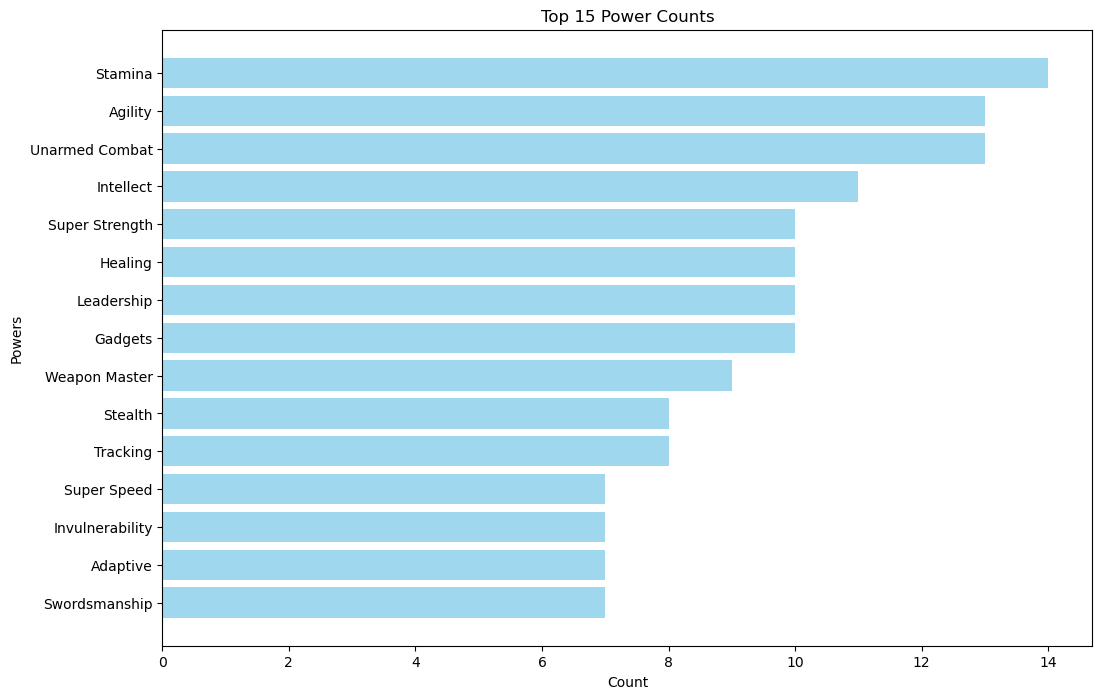

In [425]:
# Display only the top 15 powers for marvel_df
top_powers = power_df.sort_values(by='Count', ascending=False).head(15)

plt.figure(figsize=(12, 8))
plt.barh(top_powers['Power'], top_powers['Count'], color='skyblue', alpha=0.8)
plt.title("Top 15 Power Counts")
plt.xlabel("Count")
plt.ylabel("Powers")
plt.gca().invert_yaxis()  # Invert Y-axis for readability
plt.show()

In [428]:
# Display only the top 15 powers for ic_df
top_powers_image = image_df.sort_values(by='Count', ascending=False).head(15)

plt.figure(figsize=(12, 8))
plt.barh(top_powers_image['Power'], top_powers_image['Count'], color='lightcoral', alpha=0.8)
plt.title("Top 15 Powers in Image Comics")
plt.xlabel("Count")
plt.ylabel("Powers")
plt.gca().invert_yaxis()  # Invert Y-axis for readability
plt.show()

KeyError: 'Count'